In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.image import resize

## Load and Pre-process data

### load from pickle

In [2]:
#full_data = pd.read_pickle('dataset_df.pickle')
full_data = pd.read_pickle('dataset_df_120x187.pickle')
#del full_data

In [3]:
full_data.head(2)

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,image_data
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0,"[[[160, 144, 185], [146, 132, 171], [82, 94, 1..."
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0,"[[[65, 98, 156], [73, 98, 154], [74, 99, 161],..."


### get equal amounts of entries (benign, malignant)

In [4]:
malignant_df = full_data.loc[full_data['benign_malignant'] == 'malignant', :]
benign_df = full_data.loc[full_data['benign_malignant'] == 'benign', :]

print(f"Total malignant entries: {str(malignant_df.shape[0])}")
print(f"Total benign entries: {str(benign_df.shape[0])}")

sample_malignant_df_df = benign_df.sample(n=malignant_df.shape[0])

dataset_df = malignant_df.append(sample_malignant_df_df)

benign_total = dataset_df.loc[dataset_df['benign_malignant'] == 'benign', :].shape[0]
malignant_total = dataset_df.loc[dataset_df['benign_malignant'] == 'malignant', :].shape[0]
print(f"Total dataset_df entries: {str(dataset_df.shape[0])} | malignan: {malignant_total} | benign: {benign_total}")

Total malignant entries: 581
Total benign entries: 32120
Total dataset_df entries: 1162 | malignan: 581 | benign: 581


### set X and y

In [5]:
# set y
y = np.array(dataset_df['benign_malignant'])

In [6]:
# set X
X = np.array([entry for entry in dataset_df['image_data']])

In [7]:
X.size

78225840

malignant
(120, 187, 3)


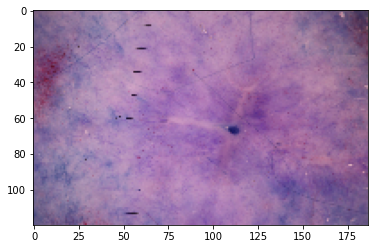

In [8]:
print(y[11])
plt.imshow(X[11])
print(X[11].shape)

In [9]:
#tmp = np.array([entry for entry in X_train])
#tmp.reshape(24525, -1).shape

### Split data into training and test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000, stratify=y)

In [11]:
print(X_train[0].shape)
print(X_train.shape)

(120, 187, 3)
(871, 120, 187, 3)


In [12]:
np.unique(y_train, return_counts=True)

(array(['benign', 'malignant'], dtype=object), array([436, 435]))

In [13]:
train_label_encoder = LabelEncoder()
train_label_encoder.fit(y_train)
y_train_encoded = train_label_encoder.transform(y_train)

test_label_encoder = LabelEncoder()
test_label_encoder.fit(y_test)
y_test_encoded = test_label_encoder.transform(y_test)

## One hot encoding

In [14]:
num_classes = 2
y_train_hencoded = to_categorical(y_train_encoded, num_classes)
y_test_hencoded = to_categorical(y_test_encoded, num_classes)

In [15]:
print(y_train_hencoded.shape)
print(y_test_hencoded.shape)

(871, 2)
(291, 2)


## Build CNN model

In [16]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.math import argmax

### Standarize the data

In [17]:
print(X_train.shape)
#X_train.map(lambda x, y: ())
#X_train_norm = normalization_layer(X_train)

(871, 120, 187, 3)


In [18]:
model = Sequential([
    Rescaling(1./255),
    Conv2D(X_train.shape[0], X_train.shape[-1], activation='relu'),
    MaxPooling2D(),
    
    Conv2D(X_train.shape[0], X_train.shape[-1], activation='relu'),
    MaxPooling2D(),
    
    Flatten(),
    #Dense(10, activation='relu'),
    Dense(units=len(train_label_encoder.classes_), activation='softmax')
])

In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
print(X_train.shape[-1])
print(y_train.shape[0])

3
871


In [21]:
# Fit the model to the training data
model.fit(
    X_train,
    y_train_hencoded,
    epochs=30,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)

Epoch 1/30
25/25 - 23s - loss: 3.9001 - accuracy: 0.5338 - val_loss: 0.7545 - val_accuracy: 0.4659
Epoch 2/30
25/25 - 17s - loss: 0.6757 - accuracy: 0.5900 - val_loss: 0.7099 - val_accuracy: 0.5568
Epoch 3/30
25/25 - 17s - loss: 0.7143 - accuracy: 0.5390 - val_loss: 0.9513 - val_accuracy: 0.4659
Epoch 4/30
25/25 - 17s - loss: 0.6906 - accuracy: 0.5223 - val_loss: 0.6088 - val_accuracy: 0.6932
Epoch 5/30
25/25 - 17s - loss: 0.6834 - accuracy: 0.5441 - val_loss: 0.6554 - val_accuracy: 0.4886
Epoch 6/30
25/25 - 17s - loss: 0.6770 - accuracy: 0.5849 - val_loss: 0.6575 - val_accuracy: 0.6932
Epoch 7/30
25/25 - 17s - loss: 0.6296 - accuracy: 0.7101 - val_loss: 0.7029 - val_accuracy: 0.5682
Epoch 8/30
25/25 - 17s - loss: 0.6187 - accuracy: 0.6743 - val_loss: 0.6536 - val_accuracy: 0.6932
Epoch 9/30
25/25 - 17s - loss: 0.6241 - accuracy: 0.6871 - val_loss: 0.6785 - val_accuracy: 0.6250
Epoch 10/30
25/25 - 17s - loss: 0.5898 - accuracy: 0.7318 - val_loss: 0.8266 - val_accuracy: 0.6705
Epoch 11/

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 120, 187, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 185, 871)     24388     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 92, 871)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 90, 871)       6828640   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 45, 871)       0         
_________________________________________________________________
flatten (Flatten)            (None, 1097460)           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2

## Model Performance

In [24]:
# Evaluate the model using the training data
model_loss, model_accuracy = model.evaluate(X_test, y_test_hencoded, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

10/10 - 2s - loss: 0.9225 - accuracy: 0.6838
Loss: 0.9225172400474548, Accuracy: 0.6838487982749939


## Validation

In [25]:
import os
def validate(img_name):
    img = cv.imread(os.path.join('.', 'validation', img_name))
    # (240, 320, 3)
    #dim = (320, 240)
    width = X_train.shape[2]
    height = X_train.shape[1]
    dim = (width, height)
    new_img = cv.resize(img, dim)

    plt.imshow(new_img)

    x_prime = new_img.reshape((1, height, width, 3))
    x_prime.shape
    prediction = model.predict(x_prime)
    print(prediction[0])
    print( test_label_encoder.inverse_transform( argmax(prediction, axis=1) ) )

[0.5483939  0.45160612]
['benign']


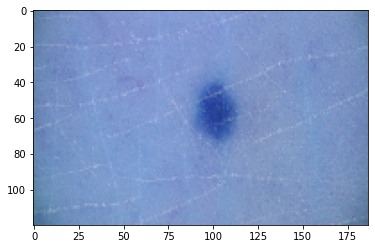

In [38]:
validate('ISIC_0463621-b.jpg')

[0.5483939  0.45160612]
['benign']


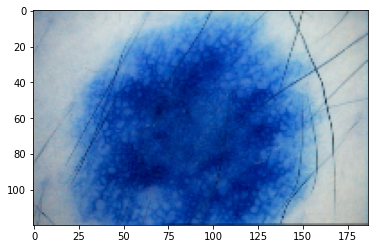

In [37]:
validate('ISIC_0362853-b.jpg')

[0.2905584 0.7094416]
['malignant']


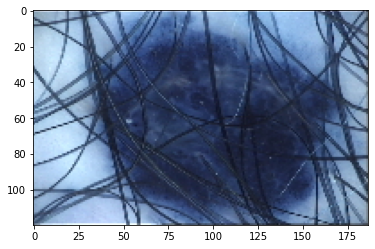

In [36]:
validate('ISIC_4012047-m.jpg')

[0.5483939  0.45160612]
['benign']


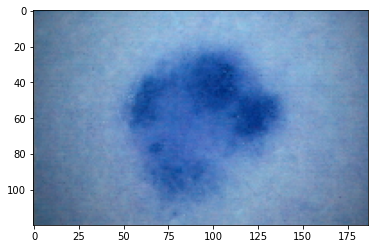

In [35]:
validate('ISIC_4619903-m.jpg')

In [39]:
# Save the model
model.save("em_model-rgb.h5")